

#### Task Structure

```
1. Imports 
2. Hyperparameters
       -- Includes learning rate, dataset path, batch size and more.
3. Loading Dataset  
4. Dataset and Dataloader
       -- Initialising dataloader
5. Model Architecture  
       -- Defining model architecture (R2U-Net and modifications for task 3)
6. Loss Function and Optimizers  
       -- Adam Optimiser and Cross Entropy Loss
7. Functions for Metrics Calculation  
       -- Calculation of 5 metrics: Specificity, Senstivity, F1 Score, Accuracy, Jaccard Score
8. Train Function 
9. Validation Function  
10. Training Epochs and Validation
       -- Perform training and calculate metrics
11. Plotting Loss over training Epochs  
       -- Show loss values over different parts of iteration
12. Plot Evaluation Metrics  
       -- Plot of 5 metrics
13. Visualizing the results
       -- Displays 5 predicted segmentation masks along with original segmentation masks
```

### 1. Imports

In [1]:
import torch
import torchvision
import os
import numpy as np
from PIL import Image
import imageio
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
import sklearn.metrics as skm
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt  
import torch.nn.functional as F
import time
import gc

### 2. Hyperparameters

In [2]:
# replace device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(0))

# replace with location of folder containing "gtFine" and "leftImg8bit"
path_data = "data"

learning_rate = 1e-3
train_epochs = 5
n_classes = 19
batch_size = 1
num_workers = 1

Using device: cuda
NVIDIA GeForce RTX 2070


### 3. Loading the dataset

In [3]:
# Adapted from dataset loader written by meetshah1995 with modifications
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py

def recursive_glob(rootdir=".", suffix=""):
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]


class cityscapesLoader(data.Dataset):
    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

    # makes a dictionary with key:value. For example 0:[128, 64, 128]
    label_colours = dict(zip(range(19), colors))

    def __init__(
        self,
        root,
        # which data split to use
        split="train",
        # transform function activation
        is_transform=True,
        # image_size to use in transform function
        img_size=(512, 256),
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}

        # makes it: /raid11/cityscapes/ + leftImg8bit + train (as we named the split folder this)
        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)
        
        # contains list of all pngs inside all different folders. Recursively iterates 
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        
        # these are 19
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,
        ]
        
        # these are 19 + 1; "unlabelled" is extra
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]
        
        # for void_classes; useful for loss function
        self.ignore_index = 250
        
        # dictionary of valid classes 7:0, 8:1, 11:2
        self.class_map = dict(zip(self.valid_classes, range(19)))

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))
        
        # prints number of images found
        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # path of image
        img_path = self.files[self.split][index].rstrip()
        
        # path of label
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )

        # read image
        #img = torchvision.io.read_image(img_path)
        img = imageio.v2.imread(img_path)
        # convert to numpy array
        #img = img.numpy()
        img = np.array(img, dtype=np.uint8)

        # read label
        #lbl = torchvision.io.read_image(img_path)
        lbl = imageio.v2.imread(lbl_path)
        # encode using encode_segmap function: 0...18 and 250
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        
        return img, lbl

    def transform(self, img, lbl):       
        # Image resize; I think imresize outputs in different format than what it received
        #img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = np.array(Image.fromarray(np.array(img).astype(np.uint8)).resize((self.img_size[0], self.img_size[1])))
        # change to BGR
        img = img[:, :, ::-1]  # RGB -> BGR
        # change data type to float64
        img = img.astype(np.float64)
        # subtract mean
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        
        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = np.array(Image.fromarray(np.array(lbl).astype(np.float32)).resize((self.img_size[0], self.img_size[1]), Image.NEAREST))
        #lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
        lbl = lbl.astype(int)

        # if not np.all(classes == np.unique(lbl)):
        #     print("WARN: resizing labels yielded fewer classes")

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl
      
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    # there are different class 0...33
    # we are converting that info to 0....18; and 250 for void classes
    # final mask has values 0...18 and 250
    def encode_segmap(self, mask):
        # !! Comment in code had wrong informtion
        # Put all void classes to ignore_index
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

### 4. Dataset and Dataloader

In [4]:
train_data = cityscapesLoader(
    root = path_data, 
    split='train'
    )

val_data = cityscapesLoader(
    root = path_data, 
    split='val'
    )

train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_data,
    batch_size = batch_size
)

Found 2975 train images
Found 500 val images


### 5. Model Architecture

In [5]:
class Up_Sample_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Up_Sample_Conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2), # Nearest neighbour for upsampling are two 
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

    
class Repeat(nn.Module):
    def __init__(self, ch_out):
        super(Repeat, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)) 
#Inplace has been set to TRUE so that it modifies the input directly, without allocating any additional output.

    def forward(self, x):
        for i in range(2):
            if i == 0:
                x_rec = self.conv(x)
            x_rec = self.conv(x + x_rec)
        return x_rec

class RR_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RR_Conv, self).__init__()
        self.Repeat_block = nn.Sequential(Repeat(ch_out),Repeat(ch_out))
        self.Conv = nn.Conv2d(ch_in, ch_out, 1, 1, 0)

    def forward(self, input_img):
        input_img = self.Conv(input_img)
        conv_input_img = self.Repeat_block(input_img)
        return input_img + conv_input_img 
    
############
############

class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=19, layers=5):
        super(R2U_Net, self).__init__()
        self.layers = layers
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.channels = [64]
        for i in range(layers-1):
            self.channels.append(2*self.channels[i])
        self.channels = torch.tensor(self.channels)
        self.channels = self.channels.to(device)
            

        '''Performs Convolution and responsible for the encoding part of the architecture'''    
        self.Layer = nn.ModuleList([RR_Conv(img_ch, self.channels[0])])
        for i in range(layers-1):
            self.Layer.append(RR_Conv(self.channels[i], self.channels[i+1]))
        self.Layer = self.Layer.to(device)


        '''Below function calls are responsible for the decoding part of the architeture'''
        

        '''Upsamples the input and then performs convolution followed by ReLU'''
        self.DeConvLayer = nn.ModuleList([])
        for i in range(layers-1):
            self.DeConvLayer.append(Up_Sample_Conv(self.channels[i+1], self.channels[i]))
        self.DeConvLayer = self.DeConvLayer.to(device)
        

        '''Responsible for computation in Recurrent Residual Blocks'''
        self.Up_Layer = nn.ModuleList([])
        for i in range(layers-1):
            self.Up_Layer.append(RR_Conv(self.channels[i+1], self.channels[i]))
        self.Up_Layer = self.Up_Layer.to(device)
        

        '''Final output of the architecture needs to have output channels=number of class labels(19)'''
        self.Conv = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1, padding=0)        
        
        
    def forward(self, x):
        '''Recurrent Convolution'''
        conv = []
        conv.append(self.Layer[0](x))
        mp = []
        mp.append(self.MaxPool(conv[0]))
        for i in range(self.layers-2):
            conv.append(self.Layer[i+1](mp[i]))
            mp.append(self.MaxPool(conv[i+1]))
        conv.append(self.Layer[-1](mp[-1]))


        ''' 
        Decoder part of the architecture which performs 
        Recurrent up convolution as well as concatention from previous layers 
        '''
        deconv = self.DeConvLayer[-1](conv[-1])
        deconv = torch.cat((conv[-2], deconv), dim=1)
        deconv = self.Up_Layer[-1](deconv)
        for i in range(self.layers-2, 0, -1):
            deconv = self.DeConvLayer[i-1](deconv)
            deconv = torch.cat((conv[i-1], deconv), dim=1)
            deconv = self.Up_Layer[i-1](deconv)
        deconv = self.Conv(deconv)

        return deconv

In [6]:
# Instance of the model defined above.
models = [R2U_Net(layers=3).to(device),R2U_Net(layers=4).to(device),R2U_Net(layers=5).to(device),R2U_Net(layers=6).to(device),R2U_Net(layers=7).to(device)]

### 6. Loss Function and Optimiser

In [7]:
optimizers = [optim.Adam(models[0].parameters(), lr=learning_rate),optim.Adam(models[1].parameters(), lr=learning_rate),optim.Adam(models[2].parameters(), lr=learning_rate),optim.Adam(models[3].parameters(), lr=learning_rate),optim.Adam(models[4].parameters(), lr=learning_rate)]

# Cross Entropy Loss adapted from meetshah1995 to prevent size inconsistencies between model precition 
# and target label
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loss/loss.py

def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss

### 7. Functions for Metrics Calculation

In [8]:
'''We have used sklearn libraries to calculate Accuracy and Jaccard Score'''

def get_metrics(gt_label, pred_label):
    #Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)
    
    #Jaccard Score/IoU
    js = skm.jaccard_score(gt_label, pred_label, average='micro')
    
    result_gm_sh = [acc, js]
    return(result_gm_sh)

'''
Calculation of confusion matrix from :
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/metrics.py

Added modifications to calculate 3 evaluation metrics - 
Specificity, Senstivity, F1 Score
'''

class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        # confusion matrix
        hist = self.confusion_matrix
        
        #              T
        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FN   TN   TN       This is wrt to class 0
        #    2   FN   TN   TN

        #         0    1    2
        #    0   TP   FP   FP
        #  P 1   FP   TP   FP       This is wrt prediction classes; AXIS = 1
        #    2   FP   FP   TP 

        #         0    1    2
        #    0   TP   FN   FN
        #  P 1   FN   TP   FN       This is wrt true classes; AXIS = 0
        #    2   FN   FN   TP   

        TP = np.diag(hist)
        TN = hist.sum() - hist.sum(axis = 1) - hist.sum(axis = 0) + np.diag(hist)
        FP = hist.sum(axis = 1) - TP
        FN = hist.sum(axis = 0) - TP
        
        # 1e-6 was added to prevent corner cases where denominator = 0
        
        # Specificity: TN / TN + FP
        specif_cls = (TN) / (TN + FP + 1e-6)
        specif = np.nanmean(specif_cls)
        
        # Senstivity/Recall: TP / TP + FN
        sensti_cls = (TP) / (TP + FN + 1e-6)
        sensti = np.nanmean(sensti_cls)
        
        # Precision: TP / (TP + FP)
        prec_cls = (TP) / (TP + FP + 1e-6)
        prec = np.nanmean(prec_cls)
        
        # F1 = 2 * Precision * Recall / Precision + Recall
        f1 = (2 * prec * sensti) / (prec + sensti + 1e-6)
        
        return (
            {
                "Specificity": specif,
                "Senstivity": sensti,
                "F1": f1,
            }
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

### 8. Train Function 

In [9]:
def train(train_loader, model, optimizer, epoch_i, epoch_total):
        count = 0
        
        # List to cumulate loss during iterations
        loss_list = []
        loss_avg = 0
        for (images, labels) in train_loader:
            count += 1
            
            # we used model.eval() below. This is to bring model back to training mood.
            model.train()

            images = images.to(device)
            labels = labels.to(device)
            
            # Model Prediction
            pred = model(images)
            # Loss Calculation
            loss = cross_entropy2d(pred, labels)
            loss_list.append(loss)

            # optimiser
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_avg += loss.item()
            # interval to print train statistics
            if count % 50 == 0:
                fmt_str = "Image: {:d} in epoch: [{:d}/{:d}] and Avg Loss of last 50: {:.4f}"
                print_str = fmt_str.format(
                    count,
                    epoch_i + 1,
                    epoch_total,
                    loss_avg/50
                )
                print(print_str)
                loss_avg = 0
                   
#           # break for testing purpose
#             if count == 10:
#                 break
        return(loss_list)

### 9. Validation Function  

In [10]:
def validate(val_loader, model, epoch_i):
    
    # tldr: to make layers behave differently during inference (vs training)
    model.eval()
    
    # enable calculation of confusion matrix for n_classes = 19
    running_metrics_val = runningScore(19)
    
    # empty list to add Accuracy and Jaccard Score Calculations
    acc_sh = []
    js_sh = []
    
    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):
            
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Model prediction
            val_pred = model(val_images)
            
            # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
            # considering predictions with highest scores for each pixel among 19 classes
            pred = val_pred.data.max(1)[1].cpu().numpy()
            gt = val_labels.data.cpu().numpy()
            
            # Updating Mertics
            running_metrics_val.update(gt, pred)
            sh_metrics = get_metrics(gt.flatten(), pred.flatten())
            acc_sh.append(sh_metrics[0])
            js_sh.append(sh_metrics[1])
                               
#            # break for testing purpose
#             if image_num == 10:
#                 break                

    score = running_metrics_val.get_scores()
    running_metrics_val.reset()
    
    acc_s = sum(acc_sh)/len(acc_sh)
    js_s = sum(js_sh)/len(js_sh)
    score["acc"] = acc_s
    score["js"] = js_s
    
    print("Different Metrics were: ", score)  
    return(score)

### 10. Training Epochs and Validation

In [11]:
if __name__ == "__main__":
    
    # to hold loss values after each epoch
    loss_all_epochs = []

    # to hold different metrics after each epoch
    Specificity_ = []
    Senstivity_ = []
    f1_ = []
    acc_ = []
    js_ = []

    for idx, model in enumerate(models):
        for epoch_i in range(train_epochs):
            # training
            print(f"Epoch {epoch_i + 1}\n-------------------------------")
            t1 = time.time()
            loss_i = train(train_loader, model, optimizers[idx], epoch_i, train_epochs)
            loss_all_epochs.append(loss_i)
            t2 = time.time()
            print("It took: ", t2-t1, " unit time")

            # metrics calculation on validation data
            dummy_list = validate(val_loader, model, epoch_i)   
            
            # Add metrics to empty list above
            Specificity_.append([dummy_list["Specificity"]])
            Senstivity_.append([dummy_list["Senstivity"]])
            f1_.append([dummy_list["F1"]])
            acc_.append([dummy_list["acc"]])
            js_.append([dummy_list["js"]])

Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/5] and Avg Loss of last 50: 3.4338
Image: 100 in epoch: [1/5] and Avg Loss of last 50: 1.7941
Image: 150 in epoch: [1/5] and Avg Loss of last 50: 1.7804
Image: 200 in epoch: [1/5] and Avg Loss of last 50: 1.7704
Image: 250 in epoch: [1/5] and Avg Loss of last 50: 1.3899
Image: 300 in epoch: [1/5] and Avg Loss of last 50: 1.4095
Image: 350 in epoch: [1/5] and Avg Loss of last 50: 1.3616
Image: 400 in epoch: [1/5] and Avg Loss of last 50: 1.3429
Image: 450 in epoch: [1/5] and Avg Loss of last 50: 1.3915
Image: 500 in epoch: [1/5] and Avg Loss of last 50: 1.5133
Image: 550 in epoch: [1/5] and Avg Loss of last 50: 1.6529
Image: 600 in epoch: [1/5] and Avg Loss of last 50: 1.2294
Image: 650 in epoch: [1/5] and Avg Loss of last 50: 1.2818
Image: 700 in epoch: [1/5] and Avg Loss of last 50: 1.1593
Image: 750 in epoch: [1/5] and Avg Loss of last 50: 1.0268
Image: 800 in epoch: [1/5] and Avg Loss of last 50: 1.3036
Image: 850 in epoch: [1/5] and Avg Loss of last 50: 1.054

500it [02:38,  3.16it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9742752558010576, 'Senstivity': 0.28853142038666985, 'F1': 0.25626414091908467, 'acc': 0.5028847961425781, 'js': 0.34899585878355294}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/5] and Avg Loss of last 50: 0.7042
Image: 100 in epoch: [2/5] and Avg Loss of last 50: 0.7439
Image: 150 in epoch: [2/5] and Avg Loss of last 50: 0.7430
Image: 200 in epoch: [2/5] and Avg Loss of last 50: 0.7177
Image: 250 in epoch: [2/5] and Avg Loss of last 50: 0.7662
Image: 300 in epoch: [2/5] and Avg Loss of last 50: 0.7074
Image: 350 in epoch: [2/5] and Avg Loss of last 50: 0.6684
Image: 400 in epoch: [2/5] and Avg Loss of last 50: 0.7905
Image: 450 in epoch: [2/5] and Avg Loss of last 50: 0.7280
Image: 500 in epoch: [2/5] and Avg Loss of last 50: 0.7276
Image: 550 in epoch: [2/5] and Avg Loss of last 50: 0.8560
Image: 600 in epoch: [2/5] and Avg Loss of last 50: 0.7409
Image: 650 in epoch: [2/5] and Avg Loss of last 50: 0.6051
Image: 700 in epo

500it [02:27,  3.40it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9731655207648034, 'Senstivity': 0.23375813823170538, 'F1': 0.21371368322848494, 'acc': 0.4704677429199219, 'js': 0.3145510198710467}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/5] and Avg Loss of last 50: 0.6147
Image: 100 in epoch: [3/5] and Avg Loss of last 50: 0.6576
Image: 150 in epoch: [3/5] and Avg Loss of last 50: 0.6663
Image: 200 in epoch: [3/5] and Avg Loss of last 50: 0.6158
Image: 250 in epoch: [3/5] and Avg Loss of last 50: 0.6624
Image: 300 in epoch: [3/5] and Avg Loss of last 50: 0.6189
Image: 350 in epoch: [3/5] and Avg Loss of last 50: 0.5713
Image: 400 in epoch: [3/5] and Avg Loss of last 50: 0.6454
Image: 450 in epoch: [3/5] and Avg Loss of last 50: 0.6226
Image: 500 in epoch: [3/5] and Avg Loss of last 50: 0.5749
Image: 550 in epoch: [3/5] and Avg Loss of last 50: 0.6153
Image: 600 in epoch: [3/5] and Avg Loss of last 50: 0.6193
Image: 650 in epoch: [3/5] and Avg Loss of last 50: 0.6065
Image: 700 in epoc

500it [02:26,  3.41it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9660516730302435, 'Senstivity': 0.27469604696524597, 'F1': 0.24721501784528557, 'acc': 0.3763561096191406, 'js': 0.23655810196333796}
Epoch 4
-------------------------------
Image: 50 in epoch: [4/5] and Avg Loss of last 50: 0.5682
Image: 100 in epoch: [4/5] and Avg Loss of last 50: 0.6304
Image: 150 in epoch: [4/5] and Avg Loss of last 50: 0.5813
Image: 200 in epoch: [4/5] and Avg Loss of last 50: 0.5223
Image: 250 in epoch: [4/5] and Avg Loss of last 50: 0.5096
Image: 300 in epoch: [4/5] and Avg Loss of last 50: 0.5237
Image: 350 in epoch: [4/5] and Avg Loss of last 50: 0.5212
Image: 400 in epoch: [4/5] and Avg Loss of last 50: 0.5390
Image: 450 in epoch: [4/5] and Avg Loss of last 50: 0.5193
Image: 500 in epoch: [4/5] and Avg Loss of last 50: 0.5136
Image: 550 in epoch: [4/5] and Avg Loss of last 50: 0.4537
Image: 600 in epoch: [4/5] and Avg Loss of last 50: 0.3990
Image: 650 in epoch: [4/5] and Avg Loss of last 50: 0.4879
Image: 700 in epo

500it [02:26,  3.41it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9635219363762667, 'Senstivity': 0.241785739522509, 'F1': 0.2379284063023527, 'acc': 0.32967117309570315, 'js': 0.2005021561509037}
Epoch 5
-------------------------------
Image: 50 in epoch: [5/5] and Avg Loss of last 50: 0.4815
Image: 100 in epoch: [5/5] and Avg Loss of last 50: 0.4665
Image: 150 in epoch: [5/5] and Avg Loss of last 50: 0.4708
Image: 200 in epoch: [5/5] and Avg Loss of last 50: 0.4524
Image: 250 in epoch: [5/5] and Avg Loss of last 50: 0.4460
Image: 300 in epoch: [5/5] and Avg Loss of last 50: 0.4459
Image: 350 in epoch: [5/5] and Avg Loss of last 50: 0.4966
Image: 400 in epoch: [5/5] and Avg Loss of last 50: 0.4615
Image: 450 in epoch: [5/5] and Avg Loss of last 50: 0.4769
Image: 500 in epoch: [5/5] and Avg Loss of last 50: 0.5517
Image: 550 in epoch: [5/5] and Avg Loss of last 50: 0.4274
Image: 600 in epoch: [5/5] and Avg Loss of last 50: 0.4540
Image: 650 in epoch: [5/5] and Avg Loss of last 50: 0.4369
Image: 700 in epoch:

500it [02:26,  3.40it/s]


Different Metrics were:  {'Specificity': 0.9754433502356711, 'Senstivity': 0.32949597438786454, 'F1': 0.2974880267423644, 'acc': 0.5383253021240234, 'js': 0.3745774308819103}
Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/5] and Avg Loss of last 50: 3.5793
Image: 100 in epoch: [1/5] and Avg Loss of last 50: 1.4601
Image: 150 in epoch: [1/5] and Avg Loss of last 50: 1.2633
Image: 200 in epoch: [1/5] and Avg Loss of last 50: 1.4323
Image: 250 in epoch: [1/5] and Avg Loss of last 50: 1.3520
Image: 300 in epoch: [1/5] and Avg Loss of last 50: 1.1818
Image: 350 in epoch: [1/5] and Avg Loss of last 50: 1.2658
Image: 400 in epoch: [1/5] and Avg Loss of last 50: 1.1730
Image: 450 in epoch: [1/5] and Avg Loss of last 50: 1.2057
Image: 500 in epoch: [1/5] and Avg Loss of last 50: 1.2766
Image: 550 in epoch: [1/5] and Avg Loss of last 50: 1.0989
Image: 600 in epoch: [1/5] and Avg Loss of last 50: 1.1461
Image: 650 in epoch: [1/5] and Avg Loss of last 50: 1.1315
Image: 700 in epoch: [1/5] and Avg Loss of last 50: 1.4325
Image: 750 in epoch: [1/5] and Avg Loss of last 50: 1.2713
Image: 800 in epoch: [1/5] and Avg Loss of last 50: 1.0253
Image: 850 in epoch: [1/5] and Avg Loss of last 50: 0.973

500it [02:46,  3.01it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.980007407425286, 'Senstivity': 0.2957386361681925, 'F1': 0.2578571499076423, 'acc': 0.5977904663085938, 'js': 0.44035678974573805}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/5] and Avg Loss of last 50: 0.7196
Image: 100 in epoch: [2/5] and Avg Loss of last 50: 0.7261
Image: 150 in epoch: [2/5] and Avg Loss of last 50: 0.7535
Image: 200 in epoch: [2/5] and Avg Loss of last 50: 0.6850
Image: 250 in epoch: [2/5] and Avg Loss of last 50: 0.6915
Image: 300 in epoch: [2/5] and Avg Loss of last 50: 0.7159
Image: 350 in epoch: [2/5] and Avg Loss of last 50: 0.6689
Image: 400 in epoch: [2/5] and Avg Loss of last 50: 0.6304
Image: 450 in epoch: [2/5] and Avg Loss of last 50: 0.6958
Image: 500 in epoch: [2/5] and Avg Loss of last 50: 0.6531
Image: 550 in epoch: [2/5] and Avg Loss of last 50: 0.6452
Image: 600 in epoch: [2/5] and Avg Loss of last 50: 0.7849
Image: 650 in epoch: [2/5] and Avg Loss of last 50: 0.6461
Image: 700 in epoch:

500it [02:36,  3.19it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9792287663920307, 'Senstivity': 0.27901393621896703, 'F1': 0.25097011324736695, 'acc': 0.57081982421875, 'js': 0.4109919505897813}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/5] and Avg Loss of last 50: 0.5694
Image: 100 in epoch: [3/5] and Avg Loss of last 50: 0.5839
Image: 150 in epoch: [3/5] and Avg Loss of last 50: 0.5846
Image: 200 in epoch: [3/5] and Avg Loss of last 50: 0.6128
Image: 250 in epoch: [3/5] and Avg Loss of last 50: 0.5591
Image: 300 in epoch: [3/5] and Avg Loss of last 50: 0.5003
Image: 350 in epoch: [3/5] and Avg Loss of last 50: 0.6029
Image: 400 in epoch: [3/5] and Avg Loss of last 50: 0.5452
Image: 450 in epoch: [3/5] and Avg Loss of last 50: 0.5676
Image: 500 in epoch: [3/5] and Avg Loss of last 50: 0.5218
Image: 550 in epoch: [3/5] and Avg Loss of last 50: 0.5746
Image: 600 in epoch: [3/5] and Avg Loss of last 50: 0.5814
Image: 650 in epoch: [3/5] and Avg Loss of last 50: 0.5537
Image: 700 in epoch:

500it [02:36,  3.19it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9789973833737344, 'Senstivity': 0.31868884351465454, 'F1': 0.26270477463110997, 'acc': 0.566934310913086, 'js': 0.4069844342676807}
Epoch 4
-------------------------------
Image: 50 in epoch: [4/5] and Avg Loss of last 50: 0.5652
Image: 100 in epoch: [4/5] and Avg Loss of last 50: 0.4123
Image: 150 in epoch: [4/5] and Avg Loss of last 50: 0.4298
Image: 200 in epoch: [4/5] and Avg Loss of last 50: 0.4227
Image: 250 in epoch: [4/5] and Avg Loss of last 50: 0.4330
Image: 300 in epoch: [4/5] and Avg Loss of last 50: 0.4599
Image: 350 in epoch: [4/5] and Avg Loss of last 50: 0.4374
Image: 400 in epoch: [4/5] and Avg Loss of last 50: 0.4956
Image: 450 in epoch: [4/5] and Avg Loss of last 50: 0.4865
Image: 500 in epoch: [4/5] and Avg Loss of last 50: 0.4830
Image: 550 in epoch: [4/5] and Avg Loss of last 50: 0.5797
Image: 600 in epoch: [4/5] and Avg Loss of last 50: 0.5015
Image: 650 in epoch: [4/5] and Avg Loss of last 50: 0.4448
Image: 700 in epoch

500it [02:35,  3.21it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9804787455012177, 'Senstivity': 0.3366387680940722, 'F1': 0.2609389935992598, 'acc': 0.5909356231689453, 'js': 0.431507964349221}
Epoch 5
-------------------------------
Image: 50 in epoch: [5/5] and Avg Loss of last 50: 0.4516
Image: 100 in epoch: [5/5] and Avg Loss of last 50: 0.4537
Image: 150 in epoch: [5/5] and Avg Loss of last 50: 0.4087
Image: 200 in epoch: [5/5] and Avg Loss of last 50: 0.3840
Image: 250 in epoch: [5/5] and Avg Loss of last 50: 0.4189
Image: 300 in epoch: [5/5] and Avg Loss of last 50: 0.5142
Image: 350 in epoch: [5/5] and Avg Loss of last 50: 0.4825
Image: 400 in epoch: [5/5] and Avg Loss of last 50: 0.4577
Image: 450 in epoch: [5/5] and Avg Loss of last 50: 0.3933
Image: 500 in epoch: [5/5] and Avg Loss of last 50: 0.5049
Image: 550 in epoch: [5/5] and Avg Loss of last 50: 0.4879
Image: 600 in epoch: [5/5] and Avg Loss of last 50: 0.4560
Image: 650 in epoch: [5/5] and Avg Loss of last 50: 0.4306
Image: 700 in epoch: 

500it [02:35,  3.21it/s]


Different Metrics were:  {'Specificity': 0.9788932601690898, 'Senstivity': 0.41068656020630434, 'F1': 0.3000038740180204, 'acc': 0.5681654052734375, 'js': 0.40869103390597017}
Epoch 1
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [1/5] and Avg Loss of last 50: 4.4424
Image: 100 in epoch: [1/5] and Avg Loss of last 50: 1.7307
Image: 150 in epoch: [1/5] and Avg Loss of last 50: 1.6485
Image: 200 in epoch: [1/5] and Avg Loss of last 50: 1.4529
Image: 250 in epoch: [1/5] and Avg Loss of last 50: 1.3434
Image: 300 in epoch: [1/5] and Avg Loss of last 50: 1.2424
Image: 350 in epoch: [1/5] and Avg Loss of last 50: 1.3998
Image: 400 in epoch: [1/5] and Avg Loss of last 50: 1.1787
Image: 450 in epoch: [1/5] and Avg Loss of last 50: 1.5809
Image: 500 in epoch: [1/5] and Avg Loss of last 50: 1.1313
Image: 550 in epoch: [1/5] and Avg Loss of last 50: 1.3235
Image: 600 in epoch: [1/5] and Avg Loss of last 50: 1.0530
Image: 650 in epoch: [1/5] and Avg Loss of last 50: 1.3728
Image: 700 in epoch: [1/5] and Avg Loss of last 50: 1.1748
Image: 750 in epoch: [1/5] and Avg Loss of last 50: 1.2297
Image: 800 in epoch: [1/5] and Avg Loss of last 50: 1.0335
Image: 850 in epoch: [1/5] and Avg Loss of last 50: 0.897

500it [02:46,  3.01it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9817114998341123, 'Senstivity': 0.25660471352388936, 'F1': 0.2416106344093409, 'acc': 0.6082723846435547, 'js': 0.44960396403667363}
Epoch 2
-------------------------------
Image: 50 in epoch: [2/5] and Avg Loss of last 50: 0.6810
Image: 100 in epoch: [2/5] and Avg Loss of last 50: 0.7410
Image: 150 in epoch: [2/5] and Avg Loss of last 50: 0.8657
Image: 200 in epoch: [2/5] and Avg Loss of last 50: 0.8958
Image: 250 in epoch: [2/5] and Avg Loss of last 50: 0.8123
Image: 300 in epoch: [2/5] and Avg Loss of last 50: 0.7830
Image: 350 in epoch: [2/5] and Avg Loss of last 50: 0.7175
Image: 400 in epoch: [2/5] and Avg Loss of last 50: 0.6968
Image: 450 in epoch: [2/5] and Avg Loss of last 50: 0.7131
Image: 500 in epoch: [2/5] and Avg Loss of last 50: 0.6800
Image: 550 in epoch: [2/5] and Avg Loss of last 50: 0.6813
Image: 600 in epoch: [2/5] and Avg Loss of last 50: 0.7322
Image: 650 in epoch: [2/5] and Avg Loss of last 50: 0.5908
Image: 700 in epoc

500it [02:47,  2.99it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.9802744738316052, 'Senstivity': 0.327031221131495, 'F1': 0.28816571631283444, 'acc': 0.6022652130126953, 'js': 0.446530578332578}
Epoch 3
-------------------------------
Image: 50 in epoch: [3/5] and Avg Loss of last 50: 0.5974
Image: 100 in epoch: [3/5] and Avg Loss of last 50: 0.5906
Image: 150 in epoch: [3/5] and Avg Loss of last 50: 0.6505
Image: 200 in epoch: [3/5] and Avg Loss of last 50: 0.5893
Image: 250 in epoch: [3/5] and Avg Loss of last 50: 0.6298
Image: 300 in epoch: [3/5] and Avg Loss of last 50: 0.5382
Image: 350 in epoch: [3/5] and Avg Loss of last 50: 0.5148
Image: 400 in epoch: [3/5] and Avg Loss of last 50: 0.6140
Image: 450 in epoch: [3/5] and Avg Loss of last 50: 0.6712
Image: 500 in epoch: [3/5] and Avg Loss of last 50: 0.5246
Image: 550 in epoch: [3/5] and Avg Loss of last 50: 0.5746
Image: 600 in epoch: [3/5] and Avg Loss of last 50: 0.5695
Image: 650 in epoch: [3/5] and Avg Loss of last 50: 0.5754
Image: 700 in epoch: 

500it [02:48,  2.98it/s]
C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Different Metrics were:  {'Specificity': 0.976866514266345, 'Senstivity': 0.2749847301010864, 'F1': 0.2491471107097721, 'acc': 0.5501211090087891, 'js': 0.3880452292752631}
Epoch 4
-------------------------------
Image: 50 in epoch: [4/5] and Avg Loss of last 50: 0.4575
Image: 100 in epoch: [4/5] and Avg Loss of last 50: 0.5163
Image: 150 in epoch: [4/5] and Avg Loss of last 50: 0.5541
Image: 200 in epoch: [4/5] and Avg Loss of last 50: 0.5007
Image: 250 in epoch: [4/5] and Avg Loss of last 50: 0.4408
Image: 300 in epoch: [4/5] and Avg Loss of last 50: 0.4913
Image: 350 in epoch: [4/5] and Avg Loss of last 50: 0.4976
Image: 400 in epoch: [4/5] and Avg Loss of last 50: 0.5432
Image: 450 in epoch: [4/5] and Avg Loss of last 50: 0.4718
Image: 500 in epoch: [4/5] and Avg Loss of last 50: 0.4477
Image: 550 in epoch: [4/5] and Avg Loss of last 50: 0.4894
Image: 600 in epoch: [4/5] and Avg Loss of last 50: 0.6031
Image: 650 in epoch: [4/5] and Avg Loss of last 50: 0.4195
Image: 700 in epoch: 

500it [02:48,  2.97it/s]


Different Metrics were:  {'Specificity': 0.9806075632146561, 'Senstivity': 0.3403367747306582, 'F1': 0.2981506543332382, 'acc': 0.6107022094726563, 'js': 0.4514202522152082}
Epoch 5
-------------------------------


C:\Users\ellio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 50 in epoch: [5/5] and Avg Loss of last 50: 0.3955
Image: 100 in epoch: [5/5] and Avg Loss of last 50: 0.4555
Image: 150 in epoch: [5/5] and Avg Loss of last 50: 0.4984
Image: 200 in epoch: [5/5] and Avg Loss of last 50: 0.4453
Image: 250 in epoch: [5/5] and Avg Loss of last 50: 0.4184
Image: 300 in epoch: [5/5] and Avg Loss of last 50: 0.4192
Image: 350 in epoch: [5/5] and Avg Loss of last 50: 0.6273
Image: 400 in epoch: [5/5] and Avg Loss of last 50: 0.4302
Image: 450 in epoch: [5/5] and Avg Loss of last 50: 0.4180
Image: 500 in epoch: [5/5] and Avg Loss of last 50: 0.4169
Image: 550 in epoch: [5/5] and Avg Loss of last 50: 0.4830
Image: 600 in epoch: [5/5] and Avg Loss of last 50: 0.4519
Image: 650 in epoch: [5/5] and Avg Loss of last 50: 0.4270
Image: 700 in epoch: [5/5] and Avg Loss of last 50: 0.4898
Image: 750 in epoch: [5/5] and Avg Loss of last 50: 0.4562
Image: 800 in epoch: [5/5] and Avg Loss of last 50: 0.4395
Image: 850 in epoch: [5/5] and Avg Loss of last 50: 0.456

500it [02:50,  2.93it/s]

Different Metrics were:  {'Specificity': 0.9803097815012416, 'Senstivity': 0.32341197180312514, 'F1': 0.3062192890046881, 'acc': 0.6050942077636718, 'js': 0.4419998937495635}


### 11. Plotting Loss over training Epochs

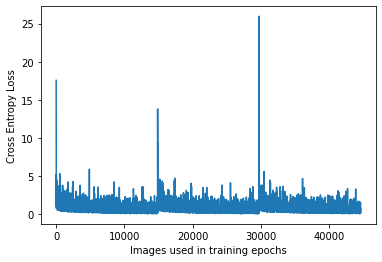

In [12]:
# loss_all_epochs: contains 2d list of tensors with: (epoch, loss tensor)
# converting to 1d list for plotting
loss_1d_list = [item for sublist in loss_all_epochs for item in sublist]
loss_list_numpy = []
for i in range(len(loss_1d_list)):
    z = loss_1d_list[i].cpu().detach().numpy()
    loss_list_numpy.append(z)
plt.xlabel("Images used in training epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(loss_list_numpy)
plt.show()

### 12. Plot Evaluation Metrics

ValueError: x and y must have same first dimension, but have shapes (5,) and (15, 1)

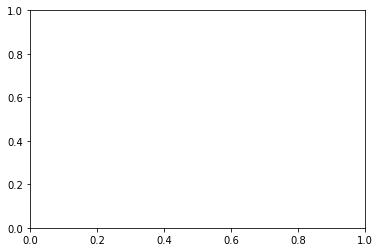

In [13]:
plt.clf()

x = [i for i in range(1, train_epochs + 1)]

# plot 5 metrics: Specificity, Senstivity, F1 Score, Accuracy, Jaccard Score
plt.plot(x,Specificity_, label='Specificity')
plt.plot(x,Senstivity_, label='Senstivity')
plt.plot(x,f1_, label='F1 Score')
plt.plot(x,acc_, label='Accuracy')
plt.plot(x,js_, label='Jaccard Score')

plt.grid(linestyle = '--', linewidth = 0.5)

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

### 13. Visualizing the Results

0it [00:00, ?it/s]

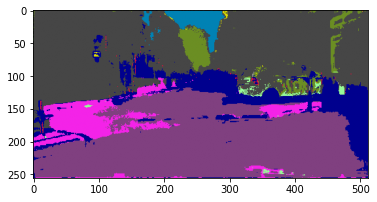

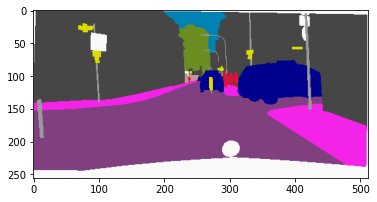

100it [00:31,  3.26it/s]

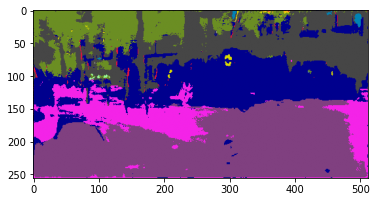

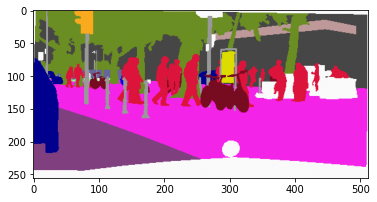

200it [01:02,  3.27it/s]

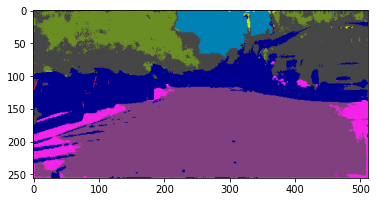

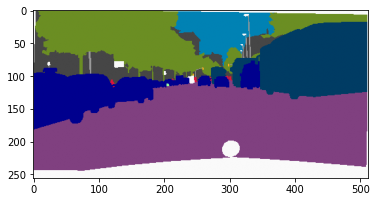

300it [01:32,  3.35it/s]

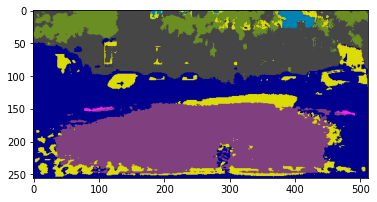

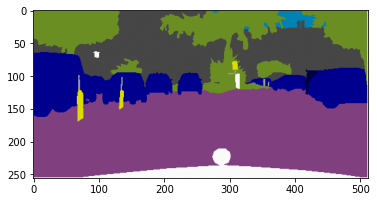

400it [02:03,  3.29it/s]

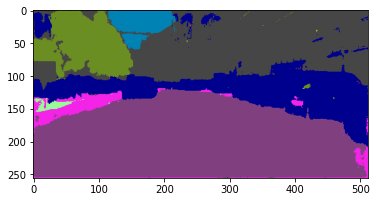

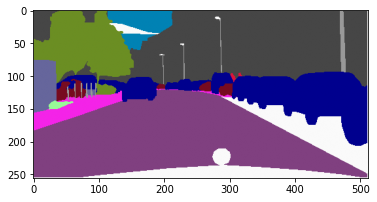

500it [02:33,  3.25it/s]


In [ ]:
# tldr: to make layers behave differently during inference (vs training)
model.eval()

with torch.no_grad():
    for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):

        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        
        # model prediction
        val_pred = model(val_images)

        # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
        # considering predictions with highest scores for each pixel among 19 classes        
        prediction = val_pred.data.max(1)[1].cpu().numpy()
        ground_truth = val_labels.data.cpu().numpy()

        # replace 100 to change number of images to print. 
        # 500 % 100 = 5. So, we will get 5 predictions and ground truths
        if image_num % 100 == 0:
            
            # Model Prediction
            decoded_pred = val_data.decode_segmap(prediction[0])
            plt.imshow(decoded_pred)
            plt.show()
            plt.clf()
            
            # Ground Truth
            decode_gt = val_data.decode_segmap(ground_truth[0])
            plt.imshow(decode_gt)
            plt.show()